# Multi-country Analysis for Transportation Infrastructure

In this notebook, we will perform a **damage and risk assessment** for transportation infrastructure, specifically focusing on roads across multiple countries. The assessment is based on combining hazard data (e.g., flood depths) with vulnerability curves to estimate the potential damage to infrastructure.

We will follow the steps outlined below to conduct the assessment:

1. **Loading the necessary packages:**  
   We will import the Python libraries required for data handling, analysis, and visualization.

2. **Loading the data:**  
   The infrastructure data (e.g., roads) and hazard data (e.g., flood depths) will be loaded into the notebook.

3. **Preparing the data:**  
   The infrastructure and hazard data will be processed and data gaps can be filled, if required.

4. **Performing the damage assessment:**  
   We will apply vulnerability curves to estimate the potential damage based on the intensity of the hazard.

5. **Visualizing the results:**  
   Finally, we will visualize the estimated damage using graphs and maps to illustrate the impact on transportation infrastructure.

## 1. Loading the Necessary Packages
To perform the assessment, we are going to make use of several [python packages](https://docs.python.org/3/tutorial/modules.html#packages).

In case you run this in Google Colab, you will have to install the packages below **(remove the hashtag in front of them)**.

In [1]:
#!pip install damagescanner
#!pip install contextily
#!pip install exactextract

In this step, we will import all the required Python libraries for data manipulation, spatial analysis, and visualization.

In [2]:
import warnings
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import shapely
from tqdm import tqdm

import matplotlib.pyplot as plt
import contextily as cx

import damagescanner.download as download
from damagescanner.core import DamageScanner
from damagescanner.osm import read_osm_data
from damagescanner.config import DICT_CIS_VULNERABILITY_FLOOD
from statistics import mode

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning) # exactextract gives a warning that is invalid

### Specify the countries of interest

Before we continue, we should specify the countries for which we want to assess the damage. We use the ISO3 code for each country to download the OpenStreetMap data.

In [3]:
countries_full_names = ['Togo','Benin','Ghana']
countries_iso3 = ['TGO','BEN','GHA']

## 2. Loading the Data
In this step, we will load four key datasets:

1. **Infrastructure data:**  
   This dataset contains information on the location and type of transportation infrastructure (e.g., roads). Each asset may have attributes such as type, length, and replacement cost.

2. **Hazard data:**  
   This dataset includes information on the hazard affecting the infrastructure (e.g., flood depth at various locations).

3. **Vulnerability curves:**  
   Vulnerability curves define how the infrastructure's damage increases with the intensity of the hazard. For example, flood depth-damage curves specify how much damage occurs for different flood depths.

4. **Maximum damage values:**  
   This dataset contains the maximum possible damage (in monetary terms) that can be incurred by individual infrastructure assets. This is crucial for calculating total damage based on the vulnerability curves.

### Infrastructure Data

We will perform this example analysis for three countries. To start the analysis, we first download the OpenStreetMap data from GeoFabrik, open it, and store it in a dictionary.

In [4]:
%%time
features_per_country = {}
for country_iso3 in countries_iso3:
    infrastructure_path = download.get_country_geofabrik(country_iso3)
    features_per_country[country_iso3] = read_osm_data(infrastructure_path,asset_type='main_roads')

CPU times: total: 25 s
Wall time: 51.3 s


Now define a new set of sub_types, to be used in the remainder of this analysis

In [5]:
sub_types = features_per_country[country_iso3].object_type.unique()

### Hazard Data
For this example, we make use of the flood data provided by [CDRI](https://giri.unepgrid.ch/map?list=explore).

We use a 1/100 flood map to showcase the approach.

In [6]:
hazard_map = xr.open_dataset("https://hazards-data.unepgrid.ch/global_pc_h100glob.tif", engine="rasterio")

In [7]:
hazard_map

<xarray.Dataset> Size: 747GB
Dimensions:      (band: 1, x: 432000, y: 216000)
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 3MB -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * y            (y) float64 2MB 90.0 90.0 90.0 90.0 ... -90.0 -90.0 -90.0 -90.0
    spatial_ref  int64 8B ...
Data variables:
    band_data    (band, y, x) float64 746GB ...

### Maximum damages
One of the most difficult parts of the assessment is to define the maximum reconstruction cost of particular assets. Here we provide a baseline set of values, but these should be updated through national consultations.

In [8]:
maxdam_dict = {'trunk':2000, 
               'motorway' : 2000,
                'primary':2000, 
                'secondary':1300, 
                'tertiary':700, 
                'trunk_link': 1300,
                'motorway_link' : 1300,
                'primary_link' : 1300,
               'secondary_link' : 700,
               'tertiary_link' : 700
              }

To be used in our damage assessment, we convert this to a Pandas DataFrame

In [9]:
maxdam = pd.DataFrame.from_dict(maxdam_dict,orient='index').reset_index()
maxdam.columns = ['object_type','damage']

And check if any of the objects are missing from the dataframe.

In [10]:
missing = set(sub_types) - set(maxdam.object_type)

if len(missing) > 0:
    print(f"Missing object types in maxdam: \033[1m{', '.join(missing)}\033[0m. Please add them before you continue.")

### Vulnerability data
Similarly to the maximum damages, specifying the vulnerability curves is complex. We generally have limited information about the quality of the assets, its level of deteriation and other asset-level characteristics. The study by Nirandjan et al. (2024) provides us with a baseline set of fragility and vulnerability curves that one can use. In the following cell, we load that data.

In [11]:
vulnerability_path = "https://zenodo.org/records/10203846/files/Table_D2_Multi-Hazard_Fragility_and_Vulnerability_Curves_V1.0.0.xlsx?download=1"
vul_df = pd.read_excel(vulnerability_path,sheet_name='F_Vuln_Depth')

And let's have a look at all the available options

In [12]:
with pd.option_context('display.max_rows', None, 'display.max_colwidth', None):
  display(vul_df.iloc[:2,:].T)

,0,1
ID number,Infrastructure description,Additional characteristics
F1.1,plant,"Small power plants, capacity <100 MW"
F1.2,plant,"Medium power plants, capacity 100-500 MW"
F1.3,plant,"Large power plants, >500 MW"
F1.4,plant,thermal plant
F1.5,plant,wind turbine
F1.6,plant,wind turbine
F1.7,plant,wind turbine
F2.1,substation,Low Voltage Substation
F2.2,substation,Medium Voltage Substation


And select a curve to use for each different subtype we are analysing. We select a curve from the database provided by Nirandjan et al. (2024).

In [13]:
ci_system = DICT_CIS_VULNERABILITY_FLOOD['main_roads']
    
selected_curves = []
for subtype in ci_system:
    selected_curves.append(ci_system[subtype][0])

damage_curves = vul_df[['ID number']+selected_curves]
damage_curves = damage_curves.iloc[4:125,:]
damage_curves.set_index('ID number',inplace=True)
damage_curves.index = damage_curves.index.rename('Depth')  
damage_curves = damage_curves.astype(np.float32)
damage_curves.columns = list(ci_system.keys())
damage_curves = damage_curves.ffill()

Make sure we set the index of the damage curves (the inundation depth) in the same metric as the hazard data (e.g. meters or centimeters). In our case, the hazard data is in centimeters, so we have to multiply our inundation values of the damage curves by 100.

In [14]:
damage_curves.index = damage_curves.index*100

In [15]:
damage_curves

,motorway,motorway_link,trunk,trunk_link,primary,primary_link,secondary,secondary_link,tertiary,tertiary_link
Depth,,,,,,,,,,
0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000
5.0,0.00200,0.00200,0.00200,0.00200,0.00200,0.00200,0.012000,0.012000,0.012000,0.012000
10.0,0.00400,0.00400,0.00400,0.00400,0.00400,0.00400,0.024000,0.024000,0.024000,0.024000
15.0,0.00600,0.00600,0.00600,0.00600,0.00600,0.00600,0.036000,0.036000,0.036000,0.036000
20.0,0.00800,0.00800,0.00800,0.00800,0.00800,0.00800,0.048000,0.048000,0.048000,0.048000
...,...,...,...,...,...,...,...,...,...,...
580.0,0.21500,0.21500,0.21500,0.21500,0.21500,0.21500,0.346500,0.346500,0.346500,0.346500
585.0,0.21625,0.21625,0.21625,0.21625,0.21625,0.21625,0.347375,0.347375,0.347375,0.347375
590.0,0.21750,0.21750,0.21750,0.21750,0.21750,0.21750,0.348250,0.348250,0.348250,0.348250


### Ancilliary data for processing

In [16]:
world = gpd.read_file("https://github.com/nvkelso/natural-earth-vector/raw/master/10m_cultural/ne_10m_admin_0_countries.shp")
world_plot = world.to_crs(3857)

In [17]:
admin1 = gpd.read_file("https://github.com/nvkelso/natural-earth-vector/raw/master/10m_cultural/ne_10m_admin_1_states_provinces.shp")

## 3. Performing the Damage Assessment
We will use the DamageScanner approach. This is a fully optimised exposure, vulnerability damage and risk calculation method, that can capture a wide range of inputs to perform such an assessment.

In [18]:
total_damage_results = {}

for country_iso3 in countries_iso3:
        
    country_bounds = world.loc[world.ADM0_ISO == country_iso3].bounds
    country_geom = world.loc[world.ADM0_ISO == country_iso3].geometry
    
    hazard_country = hazard_map.rio.clip_box(minx=country_bounds.minx.values[0],
                         miny=country_bounds.miny.values[0],
                         maxx=country_bounds.maxx.values[0],
                         maxy=country_bounds.maxy.values[0]
                        )
    features = features_per_country[country_iso3]
    
    total_damage_results[country_iso3] = DamageScanner(hazard_country, features, damage_curves, maxdam).calculate()

Calculating damage: 100%|██████████████████████████████████████████████████████| 12212/12212 [00:01<00:00, 6240.65it/s]


In [19]:
damage_results_countries = pd.concat(total_damage_results)

## 4. Save the Results
For further analysis, we can save the results in their full detail, or save summary estimates per subnational unit. We show how to do this using the damage results.

In [20]:
hazard = 'river_flood'
return_period = '1_100'
for country_iso3,country_full_name in zip(countries_iso3,countries_full_names):
    total_damage_results[country_iso3].to_file(f'Road_Damage_{country_full_name}_{hazard}_{return_period}.gpkg')

In [21]:
admin1_country = admin1.loc[admin1.sov_a3.isin(countries_iso3)]

In [22]:
damage_results_countries = damage_results_countries.sjoin(admin1_country[['adm1_code','name','geometry']])

## 5. Visualizing the Results
The results of the damage assessment can be visualized using charts and maps. This will provide a clear representation of which infrastructure is most affected by the hazard and the expected damage levels.

Plot all damages

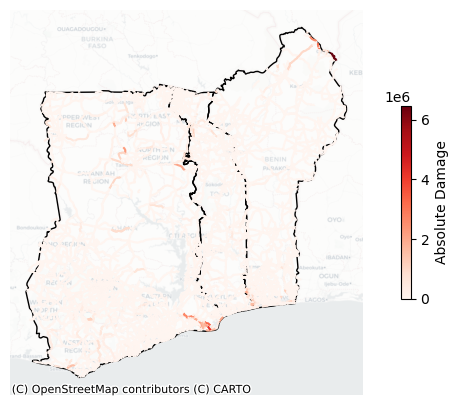

In [23]:
fig, ax = plt.subplots(1,1,figsize=(10, 5))

damage_results_countries.to_crs(3857).plot(ax=ax,column='damage',cmap='Reds',legend=True,
                   legend_kwds={'shrink': 0.5,'label':'Absolute Damage'},zorder=5)
world_plot.loc[world.SOV_A3.isin(countries_iso3)].plot(ax=ax,facecolor="none",edgecolor='black')
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron,alpha=0.5)
ax.set_axis_off()

## 9. Performing the Risk Assessment
To do so, we need to select the return periods we want to include, and create a dictionary as input. We will create this below.

In [24]:
return_periods = [2,5,10,50,100,200,500,1000]

In [25]:
total_risk_results = {}

for country_iso3 in countries_iso3:
        
    country_bounds = world.loc[world.ADM0_ISO == country_iso3].bounds
    country_geom = world.loc[world.ADM0_ISO == country_iso3].geometry
    
    hazard_country = hazard_map.rio.clip_box(minx=country_bounds.minx.values[0],
                         miny=country_bounds.miny.values[0],
                         maxx=country_bounds.maxx.values[0],
                         maxy=country_bounds.maxy.values[0]
                        )
    features = features_per_country[country_iso3]

    hazard_dict = {}
    for return_period in return_periods:
        hazard_map = xr.open_dataset(f"https://hazards-data.unepgrid.ch/global_pc_h{return_period}glob.tif", engine="rasterio")
    
        hazard_dict[return_period] = hazard_map.rio.clip_box(minx=country_bounds.minx.values[0],
                         miny=country_bounds.miny.values[0],
                         maxx=country_bounds.maxx.values[0],
                         maxy=country_bounds.maxy.values[0]
                        )
    
    total_risk_results[country_iso3] = DamageScanner(hazard_country, features, damage_curves, maxdam).risk(hazard_dict)

Risk Calculation: 100%|██████████████████████████████████████████████████████████████████| 8/8 [02:09<00:00, 16.18s/it]


## 10. Visualize the Risk Assessment
To understand the relative shares of each component of the system, we create a pie chart with the percentages of risk to each component.

In [26]:
risk_results = pd.concat(total_risk_results)

In [27]:
risk_per_object = risk_results[['object_type','risk']].groupby('object_type').sum()

In [28]:
risk_per_object

,risk
object_type,
motorway,0.000000e+00
motorway_link,0.000000e+00
primary,1.028860e+07
primary_link,2.210229e+03
secondary,2.554892e+07
secondary_link,9.021764e+02
tertiary,3.133249e+07
tertiary_link,3.288230e+05
trunk,6.364990e+06


And create some figures. We start with a figure of all countries:

Text(0.5, 1.0, 'Road Transport River Flood Risk for Togo, Benin, Ghana')

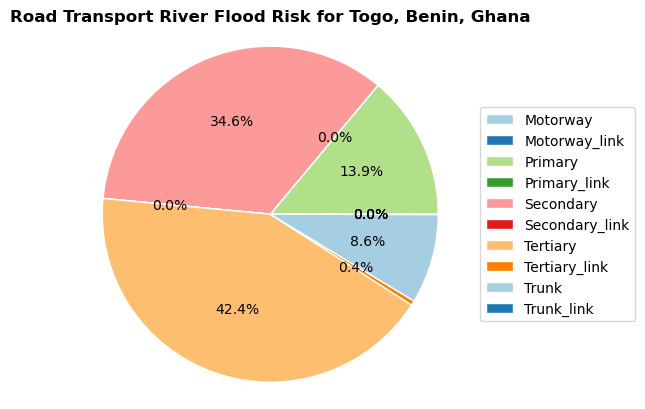

In [29]:
colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00']

labels = [x.capitalize() for x in list(risk_per_object.index)]
sizes = risk_per_object.risk.values
pie = plt.pie(sizes,autopct='%1.1f%%', labeldistance=1.15, wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white' }, colors=colors);
plt.axis('equal')
plt.legend(loc = 'right', labels=labels,bbox_to_anchor=(1.25, 0.5),)
plt.title(f'Road Transport River Flood Risk for {', '.join(countries_full_names)}',fontweight='bold')

And here an overview per country, in a single plot

In [30]:
country_risk_object = risk_results.reset_index()[['level_0','object_type','risk']].groupby(['level_0','object_type']).sum()

In [31]:
country_risk_object

risk
level_0 object_type                 
BEN     primary         4.232957e+06
        primary_link    2.210229e+03
        secondary       7.158016e+06
        secondary_link  5.744638e+02
        tertiary        1.720791e+07
        tertiary_link   3.288230e+05
        trunk           1.701110e+06
        trunk_link      2.361263e+04
GHA     motorway        0.000000e+00
        motorway_link   0.000000e+00
        primary         4.126073e+06
        primary_link    0.000000e+00
        secondary       1.322735e+07
        secondary_link  3.277127e+02
        tertiary        9.753205e+06
        tertiary_link   0.000000e+00
        trunk           3.813082e+06
        trunk_link      1.348294e+02
TGO     primary         1.929569e+06
        primary_link    0.000000e+00
        secondary       5.163552e+06
        secondary_link  0.000000e+00
        tertiary        4.371375e+06
        tertiary_link   0.000000e+00
        trunk           8.507976e+05
        trunk_link      0.000000e+00

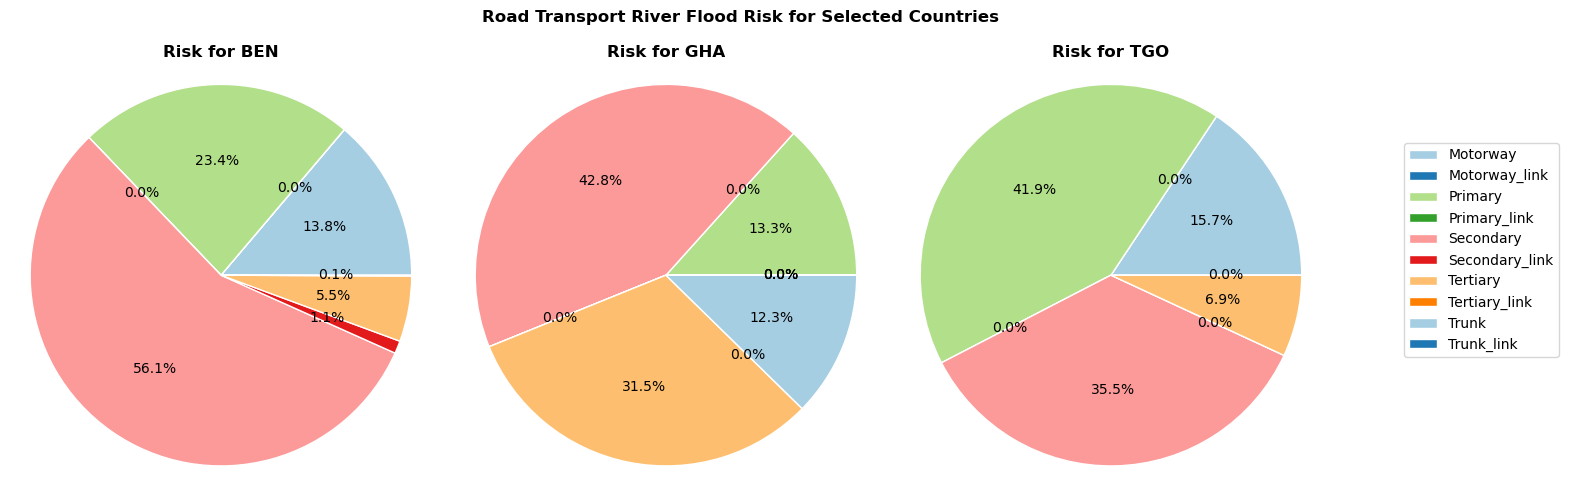

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fig.suptitle('Road Transport River Flood Risk for Selected Countries', fontweight='bold')

all_labels = list(country_risk_object.index.get_level_values(1).unique())

inputs_for_legend = []
for ax, (country, risks) in zip(axes, country_risk_object.groupby('level_0')):

    
    labels = [x.capitalize() for x in list(risks.index.get_level_values(1))]

    if len(labels) == len(all_labels):
        inputs_for_legend.append(labels)
    
    sizes = risks.risk.values
    
    pie = ax.pie(sizes, autopct='%1.1f%%', labeldistance=1.15, 
                 wedgeprops={'linewidth': 1, 'edgecolor': 'white'}, colors=colors)

    if len(pie[0]) == len(all_labels):
        inputs_for_legend.append(pie[0])

    
    ax.set_title(f'Risk for {country}', fontweight='bold')
    ax.axis('equal')

# Add a legend to the right of the figure
fig.legend(inputs_for_legend[1], inputs_for_legend[0], loc='center right', bbox_to_anchor=(1.05, 0.5))
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to fit legend